In [1]:
using PyPlot
using JLD2, FileIO
using StatsBase, LinearAlgebra, Distributions
using ForwardDiff
using Printf
Base.show(io::IO, f::Float64) = @printf(io, "%1.3f", f)

In [2]:
include("../utils.jl")
include("eval_helper.jl")
include("../lqgame.jl")

lqgame_QRE_3player (generic function with 1 method)

### dataset with demonstrations and MA-IRL

In [3]:
@load "../data/2020-08-05T17:16:09.63.jld2" data

1-element Array{Symbol,1}:
 :data

In [4]:
num_dem = length(data["demonstration_xtrajectory"])
state_dim = size(data["demonstration_xtrajectory"][1])[2]
ctrl_dim = size(data["demonstration_utrajectory"][1])[2]
steps = size(data["demonstration_xtrajectory"][1])[1]
demo_theta = data["true theta"]
println(" this is num_dem ", num_dem, " state_dim ", state_dim, " ctrl_dim ", ctrl_dim, " steps ", steps ," demo theta " , demo_theta)
demos = reshape(vcat(data["demonstration_xtrajectory"]...), (steps, num_dem, state_dim));

 this is num_dem 200 state_dim 8 ctrl_dim 4 steps 61 demo theta [1.000, 1.000, 8.000, 0.500, 0.500, 10.000]


### demonstration

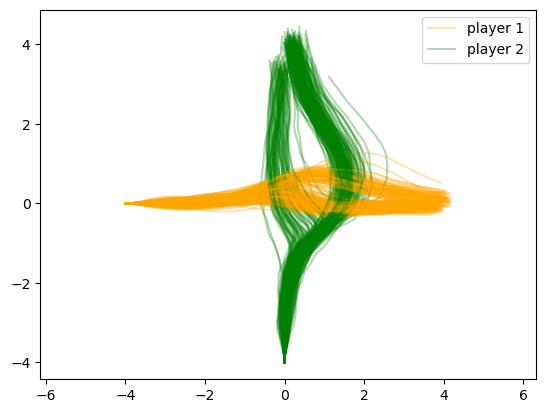

PyObject <matplotlib.legend.Legend object at 0x7fb3230dfb20>

In [5]:
fig, ax = subplots(1,1)
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.axis("equaL")
for i = 1:size(demos)[2]
    ax.plot(demos[:,i,1], demos[:,i,2], color="orange", alpha=0.3)
    ax.plot(demos[:,i,5], demos[:,i,6], color="green", alpha=0.3)
end
ax.plot(demos[:,1,1], demos[:,1,2], color="orange", alpha=0.3, label="player 1")
ax.plot(demos[:,1,5], demos[:,1,6], color="green", alpha=0.3,  label="player 2")
ax.legend()

## MA-IRL learning 

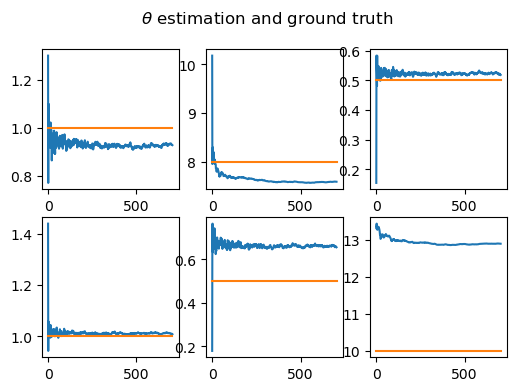

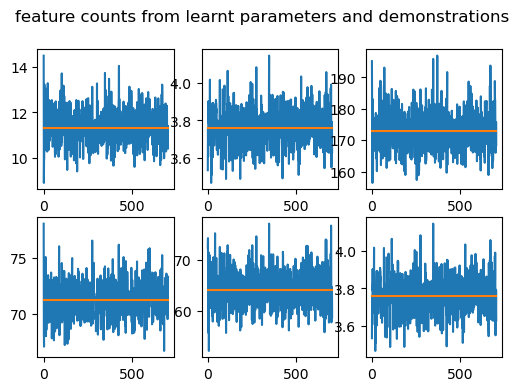

PyObject Text(0.5, 0.98, 'feature counts from learnt parameters and demonstrations')

In [6]:
num = size(data["theta_est"])[1]
# plot the theta estimation
rows = 2
cols = 3
figsize=(6,4)
fig_theta, axs_theta = subplots(rows, cols, figsize=figsize)
for (idx, ax) in enumerate(axs_theta)
    ax.plot(data["theta_est"][:,idx])
    ax.plot(ones(num) * data["true theta"][idx])
end
suptitle(L"$\theta$ estimation and ground truth")


# plot the feature counts vs. feature counts from demonstration
rows = 2
cols = 3
figsize=(6,4)
fig_fc, axs_fc = subplots(rows, cols, figsize=figsize)
for (idx, ax) in enumerate(axs_fc)
    ax.plot(data["feature_counts_proposed"][:,idx])
    ax.plot(ones(num-1) * data["feature_counts_demonstration"][idx])
end
suptitle("feature counts from learnt parameters and demonstrations")

In [7]:
# demonstration
println(" ----- demonstration ---- ")
cost_dem_1 = data["feature_counts_demonstration"][1:3]' * data["true theta"][1:3]
cost_dem_2 = data["feature_counts_demonstration"][4:end]' * data["true theta"][4:end]
println(" demo feature counts ", data["feature_counts_demonstration"][1:3], " ", data["feature_counts_demonstration"][4:end])
println(" true theta          ", data["true theta"][1:3], " ", data["true theta"][4:end])
println(" this is demonstrated cost: player 1- ", cost_dem_1, " and player 2- ", cost_dem_2)


# estimation
println(" ----- estimation ---- ")
if size(data["feature_counts_proposed"])[1] > 20
    fc_avg = mean(data["feature_counts_proposed"][end-20:end,:], dims=1)[:]
    theta_avg = mean(data["theta_est"][end-20:end,:], dims=1)[:]
else
    fc_avg = mean(data["feature_counts_proposed"][1:end,:], dims=1)[:]
    theta_avg = mean(data["theta_est"][1:end,:], dims=1)[:]
end
pause(1.0)
println(" est feature counts ", fc_avg[1:3], " ", fc_avg[4:end])
println(" estimated  theta   ", theta_avg[1:3], " ", theta_avg[4:end])
cost_est_1 = fc_avg[1:3]' * theta_avg[1:3]
cost_est_2 = fc_avg[4:end]' * theta_avg[4:end]
println(" this is estimated cost: player 1- ", cost_est_1, " and player 2- ", cost_est_2)

 ----- demonstration ---- 
 demo feature counts [11.330, 71.217, 3.761] [64.199, 172.789, 3.761]
 true theta          [1.000, 1.000, 8.000] [0.500, 0.500, 10.000]
 this is demonstrated cost: player 1- 112.636 and player 2- 156.106
 ----- estimation ---- 
 est feature counts [11.234, 71.537, 3.768] [64.217, 173.113, 3.768]
 estimated  theta   [0.932, 1.011, 7.585] [0.661, 0.521, 12.904]
 this is estimated cost: player 1- 111.387 and player 2- 181.326


### apply to other tasks 

In [8]:
theta_mairl = theta_avg    # tracking, control collision
steps = 60
horizon = 6.0
plan_steps = 10
state_dims = [4, 4]
ctrl_dims = [2, 2]
DT = horizon/steps

sim_param = SimulationParams(steps=steps, horizon=horizon, plan_steps=plan_steps)
mairl_game = NonlinearGame(state_dims, ctrl_dims, DT; theta=theta_mairl)
true_game = NonlinearGame(state_dims, ctrl_dims, DT; theta=demo_theta)

x_init = [-4.0 0.0 1.0 0.0      2.83 2.83 1.33 -3*pi/4]
x_ref = zeros(steps*2, mairl_game.state_dim)
x_ref[1,:] = x_init
for i=1:steps*2 - 1
    x_ref[i+1,:] = mairl_game.dynamics_func([x_ref[i,:]; zeros(mairl_game.ctrl_dim)])
end

#=============
generate simulations using estimated theta and true theta
==============#
feature_k = length(theta_mairl)
mairl_results = generate_simulations(sim_param=sim_param,
                                   nl_game=mairl_game,
                                   x_init=x_init,
                                   traj_ref=x_ref,
                                   num_sim=200);
x_trajectories_mairl = mairl_results.state_trajectories;
u_trajectories_mairl = mairl_results.ctrl_trajectories;

true_results = generate_simulations(sim_param=sim_param,
                                   nl_game=true_game,
                                   x_init=x_init,
                                   traj_ref=x_ref,
                                   num_sim=200);
x_trajectories_true = true_results.state_trajectories;
u_trajectories_true = true_results.ctrl_trajectories;

 --- generating sim number : 3 ---
 --- generating sim number : 6 ---
 --- generating sim number : 9 ---
 --- generating sim number : 12 ---
 --- generating sim number : 15 ---
 --- generating sim number : 18 ---
 --- generating sim number : 21 ---
 --- generating sim number : 24 ---
 --- generating sim number : 27 ---
 --- generating sim number : 30 ---
 --- generating sim number : 33 ---
 --- generating sim number : 36 ---
 --- generating sim number : 39 ---
 --- generating sim number : 42 ---
 --- generating sim number : 45 ---
 --- generating sim number : 48 ---
 --- generating sim number : 51 ---
 --- generating sim number : 54 ---
 --- generating sim number : 57 ---
 --- generating sim number : 60 ---
 --- generating sim number : 63 ---
 --- generating sim number : 66 ---
 --- generating sim number : 69 ---
 --- generating sim number : 72 ---
 --- generating sim number : 75 ---
 --- generating sim number : 78 ---
 --- generating sim number : 81 ---
 --- generating sim number : 84

In [9]:
# compare feature counts/ task statistics 
avg_feature_counts_mairl = get_feature_counts(mairl_game, 
                                x_trajectories_mairl, 
                                u_trajectories_mairl, 
                                x_ref, feature_k)
avg_feature_counts_true = get_feature_counts(mairl_game, 
                                x_trajectories_true, 
                                u_trajectories_true, 
                                x_ref, feature_k)

([4.933; 66.290; … ; 145.801; 2.396], [4.777 6.949 … 2.698 4.626; 79.150 61.433 … 71.436 49.877; … ; 159.124 163.446 … 147.704 119.119; 2.458 2.520 … 2.151 2.425])

# baseline comparison 

- CIOC:
    * learn the reward parameters separately 
- plan with QRE 
- plan separately without interactive planning

#### plan with QRE

In [12]:
# theta value from cioc
cioc_theta = [2.4807054, 1., 8.36532665, 0.66685417, 0.5, 7.8541684];    # tracking, control, collision 

In [13]:
cioc_game = NonlinearGame(state_dims, ctrl_dims, DT; theta=cioc_theta)

#=============
generate simulations
==============#
feature_k = length(cioc_theta)
cioc_results = generate_simulations(sim_param=sim_param,
                                   nl_game=cioc_game,
                                   x_init=x_init,
                                   traj_ref=x_ref,
                                   num_sim=200)
x_trajectories_cioc = cioc_results.state_trajectories
u_trajectories_cioc = cioc_results.ctrl_trajectories

 --- generating sim number : 3 ---
 --- generating sim number : 6 ---
 --- generating sim number : 9 ---
 --- generating sim number : 12 ---
 --- generating sim number : 15 ---
 --- generating sim number : 18 ---
 --- generating sim number : 21 ---
 --- generating sim number : 24 ---
 --- generating sim number : 27 ---
 --- generating sim number : 30 ---
 --- generating sim number : 33 ---
 --- generating sim number : 36 ---
 --- generating sim number : 39 ---
 --- generating sim number : 42 ---
 --- generating sim number : 45 ---
 --- generating sim number : 48 ---
 --- generating sim number : 51 ---
 --- generating sim number : 54 ---
 --- generating sim number : 57 ---
 --- generating sim number : 60 ---
 --- generating sim number : 63 ---
 --- generating sim number : 66 ---
 --- generating sim number : 69 ---
 --- generating sim number : 72 ---
 --- generating sim number : 75 ---
 --- generating sim number : 78 ---
 --- generating sim number : 81 ---
 --- generating sim number : 84

200-element Array{Any,1}:
 [0.449 0.722 0.740 0.292; -0.439 0.516 0.560 -0.435; … ; 3.224 0.182 -0.282 0.578; -0.384 0.215 -0.993 -0.531]
 [0.066 -0.791 1.470 1.806; -0.277 -0.267 -1.781 0.731; … ; 0.055 0.772 0.365 1.461; -0.243 -0.617 -0.352 1.716]
 [1.078 -0.177 0.001 -0.684; 0.799 -0.109 -0.554 0.811; … ; -0.644 0.281 0.356 0.469; -0.135 1.184 1.224 0.513]
 [-0.187 -0.463 0.363 2.422; -0.307 -0.412 0.746 0.661; … ; 0.076 -0.319 0.901 0.004; -0.090 0.312 0.281 -0.681]
 [-0.662 -0.164 -0.098 -0.445; 0.273 0.809 -0.655 0.197; … ; 0.030 -0.047 -0.645 1.365; -1.274 -0.937 -0.271 -2.150]
 [0.855 0.360 -1.266 -0.680; -0.571 -0.732 0.010 0.708; … ; -0.581 0.082 -0.573 -0.189; 1.438 -0.410 -0.451 -1.155]
 [0.203 -0.191 -0.143 0.572; 0.907 -0.106 2.565 1.030; … ; 0.134 -0.312 -0.443 2.475; 0.224 -0.780 -0.894 0.247]
 [-0.435 0.595 0.841 -0.288; 0.300 -0.899 0.679 0.762; … ; -0.766 -0.081 0.024 0.605; 0.838 0.254 -0.004 -0.803]
 [-0.772 0.203 0.483 -0.520; -0.403 -0.147 -0.453 -0.694; … ; -1.

In [17]:
avg_dem_feature_counts_cioc, all_counts_cioc = get_feature_counts(true_game, x_trajectories_cioc, u_trajectories_cioc, x_ref, feature_k)
println("mairl theta on task:    ", avg_feature_counts_mairl[1])
println("true theta on task:     ", avg_feature_counts_true[1])
println("cioc theta on task:     ", avg_dem_feature_counts_cioc)

mairl theta on task:    [4.685; 64.553; 2.320; 27.554; 137.557; 2.320]
true theta on task:     [4.933; 66.290; 2.396; 30.313; 145.801; 2.396]
cioc theta on task:     [2.195; 64.160; 2.972; 19.513; 140.764; 2.972]


# comparison

#### feature counts 

In [15]:
println("    feature counts ")
println("         tracking1 ctrl1   coll1    tracking2 ctrl2   coll2")
println("demo      ", avg_feature_counts_mairl[1])
println("MA-IRL    ", avg_feature_counts_true[1])
println("CIOC      ", avg_dem_feature_counts_cioc)

    feature counts 
         tracking1 ctrl1   coll1    tracking2 ctrl2   coll2
demo      [4.685; 64.553; 2.320; 27.554; 137.557; 2.320]
MA-IRL    [4.933; 66.290; 2.396; 30.313; 145.801; 2.396]
CIOC      [2.195; 64.160; 2.972; 19.513; 140.764; 2.972]


#### generated trajectories 

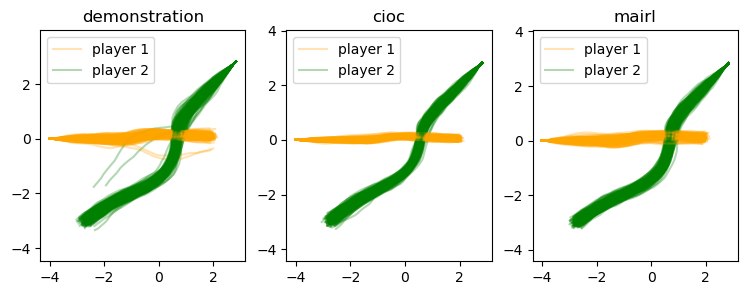

PyObject Text(0.5, 1.0, 'mairl')

In [16]:
fig, ax = subplots(1,3, figsize=(9,3))

ax[1].set_xlim(-5, 5)
ax[1].set_ylim(-5, 5)
ax[1].axis("equaL")
for i = 1:size(x_trajectories_true)[1]
    xx = x_trajectories_true[i]
    ax[1].plot(xx[:,1], xx[:,2], color="orange", alpha=0.3)
    ax[1].plot(xx[:,5], xx[:,6], color="green", alpha=0.3)
end
ax[1].plot(x_trajectories_true[1][:,1], x_trajectories_true[1][:,2], color="orange", alpha=0.3, label="player 1")
ax[1].plot(x_trajectories_true[1][:,5], x_trajectories_true[1][:,6], color="green", alpha=0.3,  label="player 2")
ax[1].legend()
ax[1].set_title("demonstration")

ax[2].set_xlim(-5, 5)
ax[2].set_ylim(-5, 5)
ax[2].axis("equal")
for i = 1:size(x_trajectories_cioc)[1]
    xx = x_trajectories_cioc[i]
    ax[2].plot(xx[:,1], xx[:,2], color="orange", alpha=0.3)
    ax[2].plot(xx[:,5], xx[:,6], color="green", alpha=0.3)
end
ax[2].plot(x_trajectories_cioc[1][:,1], x_trajectories_cioc[1][:,2], color="orange", alpha=0.3, label="player 1")
ax[2].plot(x_trajectories_cioc[1][:,5], x_trajectories_cioc[1][:,6], color="green", alpha=0.3,  label="player 2")
ax[2].legend()
ax[2].set_title("cioc")


ax[3].set_xlim(-5, 5)
ax[3].set_ylim(-5, 5)
ax[3].axis("equal")
for i = 1:size(x_trajectories_mairl)[1]
    xx = x_trajectories_mairl[i]
    ax[3].plot(xx[:,1], xx[:,2], color="orange", alpha=0.3)
    ax[3].plot(xx[:,5], xx[:,6], color="green", alpha=0.3)
end
ax[3].plot(x_trajectories_mairl[1][:,1], x_trajectories_mairl[1][:,2], color="orange", alpha=0.3, label="player 1")
ax[3].plot(x_trajectories_mairl[1][:,5], x_trajectories_mairl[1][:,6], color="green", alpha=0.3,  label="player 2")
ax[3].legend()
ax[3].set_title("mairl")